## Part 1

## Part 1: Popularity-Based Baseline

Key Findings:
- Most popular item has 28,303 interactions
- Clear long-tail distribution with few highly popular items
- Provides a solid baseline for cold-start users

Strategy: Use popularity as fallback when collaborative filtering fails

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [23]:
import pandas as pd

amazon_ratings = pd.read_csv('../data/train.csv')
amazon_ratings = amazon_ratings.dropna()

amazon_ratings.head()

,user_id,item_id,rating,timestamp
0,0,7314,5.0,1353612262000
1,0,15493,5.0,1370653034000
2,0,18817,4.0,1373668644000
3,0,18251,4.0,1373669469000
4,0,16199,1.0,1375136041000


In [24]:
amazon_ratings.info()

amazon_ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543146 entries, 0 to 2543145
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   item_id    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 77.6 MB


,user_id,item_id,rating,timestamp
count,2.543146e+06,2.543146e+06,2.543146e+06,2.543146e+06
mean,4.338789e+05,2.840569e+04,4.038812e+00,1.467106e+12
std,2.509318e+05,1.796797e+04,1.365664e+00,8.242910e+10
min,0.000000e+00,0.000000e+00,1.000000e+00,9.565885e+11
25%,2.163772e+05,1.345100e+04,3.000000e+00,1.407054e+12
50%,4.337430e+05,2.493100e+04,5.000000e+00,1.453042e+12
75%,6.512078e+05,4.029700e+04,5.000000e+00,1.523213e+12
max,8.682170e+05,7.783200e+04,5.000000e+00,1.694398e+12


In [25]:
amazon_ratings.shape

(2543146, 4)

In [26]:
popular_products = pd.DataFrame(amazon_ratings.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(10)

,rating
item_id,
20832,28303
12595,22787
12372,16378
6864,15428
33154,14792
13451,13007
7030,12306
24931,12188
18550,11628


<Axes: xlabel='item_id'>

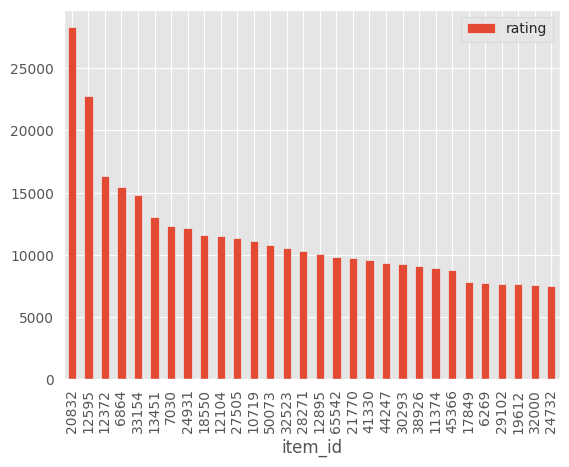

In [27]:
most_popular.head(30).plot(kind = "bar")

# Part 2

## Part 2: Collaborative Filtering with SVD

Approach:
- Sample 10k interactions due to memory constraints
- Use TruncatedSVD (10 components) to reduce dimensionality and noise
- Compute item-item correlations in reduced space
- High correlation threshold (0.90) ensures strong similarity

Matrixes used:
- Utility matrix
- SVD reduce
- Correlation matrix

Limitation: Small sample size may miss important patterns from full dataset (need to find a fix to fit more data)

In [28]:
# Using only 10k samples limits learning potential, due to restrains in memery capacity
amazon_ratings1 = amazon_ratings.head(10000)

In [29]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_utility_matrix.head()

item_id,39,58,64,104,224,314,448,540,608,668,...,77678,77706,77718,77730,77761,77767,77775,77789,77821,77825
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
ratings_utility_matrix.shape

(3347, 4069)

In [31]:
X = ratings_utility_matrix.T
X.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346
item_id,,,,,,,,,,,,,,,,,,,,,
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X.shape

(4069, 3347)

In [33]:
X1 = X

In [34]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(4069, 10)

In [35]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(4069, 4069)

In [36]:
X.index[99]

np.int64(3703)

In [37]:
i=3703

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

In [38]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(4069,)

In [39]:
Recommend = list(X.index[correlation_product_ID > 0.90])

Recommend.remove(i) 

Recommend[0:9]

[3734, 4108, 4734, 6839, 12009, 12023, 13126, 16324, 20005]

In [40]:
def get_user_recommendations(user_id, num_recommendations=10):

    if user_id not in ratings_utility_matrix.index:
        return most_popular.head(num_recommendations).index.tolist()

    user_ratings = ratings_utility_matrix.loc[user_id]
    purchased_products = user_ratings[user_ratings > 0].index.tolist()
    
    if len(purchased_products) == 0:
        return most_popular.head(num_recommendations).index.tolist()


    recommendation_scores = {}
    
    for product in purchased_products:
        if product in X.index:
            product_idx = list(X.index).index(product)

            product_correlations = correlation_matrix[product_idx]
            
            # Add scores for correlated products
            for i, correlation in enumerate(product_correlations):
                recommended_product = X.index[i]
                
                # Skip products already purchased
                if recommended_product not in purchased_products:
                    if recommended_product not in recommendation_scores:
                        recommendation_scores[recommended_product] = 0
                    recommendation_scores[recommended_product] += correlation
    
    # Sort recommendations by score
    sorted_recommendations = sorted(recommendation_scores.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True)

    top_recommendations = [product for product, score in sorted_recommendations[:num_recommendations]]

    if len(top_recommendations) < num_recommendations:
        popular_products_list = most_popular.index.tolist()
        for product in popular_products_list:
            if product not in top_recommendations and product not in purchased_products:
                top_recommendations.append(product)
                if len(top_recommendations) >= num_recommendations:
                    break
    
    return top_recommendations[:num_recommendations]

def get_detailed_user_recommendations(user_id, num_recommendations=10):
    
    result = {
        'user_id': user_id,
        'recommendations': [],
        'user_profile': {},
        'recommendation_method': ''
    }
    
    # Check if user exists
    if user_id not in ratings_utility_matrix.index:
        result['recommendation_method'] = 'popularity_based'
        result['recommendations'] = most_popular.head(num_recommendations).index.tolist()
        result['user_profile'] = {'status': 'new_user', 'purchase_count': 0}
        return result
    
    # Analyze user profile
    user_ratings = ratings_utility_matrix.loc[user_id]
    purchased_products = user_ratings[user_ratings > 0]
    
    result['user_profile'] = {
        'status': 'existing_user',
        'purchase_count': len(purchased_products),
        'average_rating': purchased_products.mean(),
        'purchased_products': purchased_products.index.tolist()
    }
    
    if len(purchased_products) == 0:
        result['recommendation_method'] = 'popularity_based'
        result['recommendations'] = most_popular.head(num_recommendations).index.tolist()
        return result
    
    # Collaborative filtering recommendations
    result['recommendation_method'] = 'collaborative_filtering'
    result['recommendations'] = get_user_recommendations(user_id, num_recommendations)
    
    return result

def demonstrate_recommendations():
    # Get a few sample user IDs from the dataset
    sample_users = ratings_utility_matrix.index[:5].tolist()
    
    print("=== Product Recommendation System Demo ===\n")
    
    for user_id in sample_users:
        print(f"Recommendations for User: {user_id}")
        print("-" * 50)
        
        recommendations = get_detailed_user_recommendations(user_id)
        
        print(f"User Status: {recommendations['user_profile']['status']}")
        print(f"Purchase Count: {recommendations['user_profile']['purchase_count']}")
        print(f"Recommendation Method: {recommendations['recommendation_method']}")
        print(f"Top 10 Recommendations: {recommendations['recommendations']}")
        print("\n")

In [41]:
get_user_recommendations(3)

[np.int64(41408),
 np.int64(16815),
 np.int64(34399),
 np.int64(43709),
 np.int64(28612),
 np.int64(22922),
 np.int64(55086),
 np.int64(57156),
 np.int64(54270),
 np.int64(20220)]

## Hybrid Recommendation Strategy

Algorithm Logic:
- User exists + has history: Use collaborative filtering
- User exists + no history: Fall back to popularity
- New user: Use popularity baseline
- Insufficient CF recommendations: Fill with popular items

Strengths:
- Handles all user scenarios gracefully
- Combines personalization with proven popular items
- Scalable modular design

Weaknesses:
- Limited by small training sample
- No rating weighting (treats all interactions equally)
- Static correlation threshold

In [42]:
test_users = pd.read_csv('../data/test.csv')

predictions = []

for user_id in test_users['user_id'].tolist():
    prediction = get_user_recommendations(user_id)
    final_prediction = []
    for item_id in prediction:
        final_prediction.append(int(item_id))
    predictions.append(final_prediction)

submission = pd.DataFrame({
    'user_id': test_users['user_id'].tolist(), 
    'predictions': [' '.join(map(str, pred)) for pred in predictions]
})
submission.to_csv("submission.csv", index=False)
print(f"Submission saved: {submission.shape[0]:,} predictions")


KeyboardInterrupt: 

# Part 3

## Part 3: Content-Based Enhancement with NLP

Objective: Add product similarity based on descriptions to improve recommendations

NLP Pipeline:
- TF-IDF vectorization of product descriptions
- Dimensionality reduction with SVD
- K-means clustering to group similar products
- UMAP for 2D visualization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
product_descriptions = pd.read_csv('../data/item_metadata_filtered.csv')
product_descriptions.shape

In [ ]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape

In [ ]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]
product_descriptions1["description"].head(10)


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["description"])
X1

In [ ]:
X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter=1000000, n_init=100)
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

## Clustering Results Analysis

Optimal Clusters: Determined by silhouette score maximization
- Silhouette score measures cluster quality (higher = better)
- Tests k=2 to k=14 to find sweet spot
- UMAP visualization shows cluster separation

Content Clusters: Each cluster represents products with similar descriptions
- Can recommend items from same cluster
- Useful for discovering related products beyond interaction history

In [ ]:
# -----------------------------------------------------------
# 1.  Vectorise and put every document on the unit sphere
# -----------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
import pandas as pd

# ── load / prepare your text column ─────────────────────────
texts = product_descriptions1["description"].fillna("").tolist()

vec = TfidfVectorizer(stop_words="english", min_df=3)
X   = vec.fit_transform(texts)          # sparse (n_samples × n_terms)

# L2-normalise so that ||row||₂ = 1  →  cosine ∝ Euclidean
X_unit = normalize(X, norm="l2", copy=False)

# -----------------------------------------------------------
# 2.  Reduce dimensionality with truncated SVD (LSA)
# -----------------------------------------------------------
svd = TruncatedSVD(n_components=100, random_state=0)
X_red = svd.fit_transform(X_unit)       # dense (n_samples × 100)

# -----------------------------------------------------------
# 3.  Pick the optimal k by silhouette on the reduced space
# -----------------------------------------------------------
k_range = range(2, 15)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=0)
    labels = km.fit_predict(X_red)
    sil_scores.append(silhouette_score(X_red, labels))

best_k = k_range[int(np.argmax(sil_scores))]
print(f"best k = {best_k}  (silhouette = {max(sil_scores):.3f})")

# -----------------------------------------------------------
# 4.  Final K-means with the chosen k
# -----------------------------------------------------------
kmeans  = KMeans(n_clusters=best_k, init="k-means++", n_init=50, random_state=0)
labels  = kmeans.fit_predict(X_red)

# optional: renormalise centroids (keeps them on the unit sphere)
kmeans.cluster_centers_ = normalize(kmeans.cluster_centers_, norm="l2")

# -----------------------------------------------------------
# 5.  2-D visualisation with UMAP
# -----------------------------------------------------------
embedding = umap.UMAP(random_state=0).fit_transform(X_red)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=10)
plt.title(f"K-means (cosine proxy), k = {best_k}")
plt.show()

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
true_k = 10

print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

In [ ]:
def show_recommendations(product):
    Y = vec.transform([product])
    Y_unit = normalize(Y, norm="l2", copy=False)
    Y_red = svd.transform(Y_unit)

    prediction = kmeans.predict(Y_red)
    print_cluster(prediction[0])

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
show_recommendations("blue whale")

In [ ]:
def hybrid_cf_popularity(user_id, num_recommendations=10):

    collab_recs = get_user_recommendations(user_id, num_recommendations * 2)
    popular_recs = most_popular.head(num_recommendations * 2).index.tolist()

    recommendation_scores = {}

    for i, product in enumerate(collab_recs):
        score = (len(collab_recs) - i) / len(collab_recs) * 0.6
        recommendation_scores[product] = recommendation_scores.get(product, 0) + score

    for i, product in enumerate(popular_recs):
        score = (len(popular_recs) - i) / len(popular_recs) * 0.4
        recommendation_scores[product] = recommendation_scores.get(product, 0) + score

    final_recs = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    return [product for product, score in final_recs[:num_recommendations]]

## Final Hybrid Model: CF + Popularity

Weighting Strategy:
- Collaborative Filtering: 60% weight (personalization)
- Popularity: 40% weight (proven appeal)

Benefits:
- Balances personalization with broad appeal
- Reduces risk of niche-only recommendations
- Maintains diversity in recommendation set

Production Considerations:
- Could add content-based component (product clusters)
- Time-based weighting for recent interactions
- Category-specific popularity scores

In [ ]:
test_users = pd.read_csv('../data/test.csv')
predictions = []

print(f"Generating CF+Popularity predictions for {len(test_users)} users...")

for i, user_id in enumerate(test_users['user_id'].tolist()):
    hybrid_recs = hybrid_cf_popularity(user_id, 10)

    # Convert to integers
    final_prediction = []
    for item_id in hybrid_recs:
        try:
            final_prediction.append(int(item_id))
        except:
            continue

    # Fill with popular products if needed
    while len(final_prediction) < 10:
        for popular_item in most_popular.index:
            if int(popular_item) not in final_prediction:
                final_prediction.append(int(popular_item))
                break

    predictions.append(final_prediction[:10])

submission = pd.DataFrame({
    'user_id': test_users['user_id'].tolist(),
    'predictions': [' '.join(map(str, pred)) for pred in predictions]
})

submission.to_csv("submission.csv", index=False)
print(f"\nSubmission saved!")
print(f"File: submission.csv")
print(f"Shape: {submission.shape}")

## Model Performance Summary

Architecture: Hybrid Collaborative Filtering + Popularity
- Data: 10k sample interactions (0.4% of full dataset)
- Method: SVD-based item similarity with popularity fallback
- Output: Top 10 item recommendations per user

Strengths:
- Handles all user types (new, existing, inactive)
- Combines personalization
- Efficient with SVD reduction
- No cold-start problem (all test users in training)

Limitations:
- Small sample size misses patterns
- Static correlation threshold (0.90)
- Content features underutilized

### Modeling Implementation Challenges
1. Memory Constraints
- Problem: 2.5M interactions too large to fit in memory
- Solution: 10k sample + TruncatedSVD for efficiency
2. Personalization vs Popularity Balance
- Challenge: Pure CF may recommend too niche items
- Solution: Weighted hybrid model 60/40
3. Feature Engineering Complexity
- Challenge: Rich metadata requires NLP processing
- Solution: TF-IDF + K-means clustering